In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        os.path.join(dirname, filename)


In [4]:
pip install tensorflow


     ---------------------------------------- 0.0/46.2 kB ? eta -:--:--
     ---------------------------------------- 46.2/46.2 kB 2.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/377.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/377.0 MB 25.4 MB/s eta 0:00:15
   ---------------------------------------- 1.8/377.0 MB 22.3 MB/s eta 0:00:17
   ---------------------------------------- 2.8/377.0 MB 22.7 MB/s eta 0:00:17
   ---------------------------------------- 3.8/377.0 MB 24.5 MB/s eta 0:00:16
    --------------------------------------- 5.1/377.0 MB 25.2 MB/s eta 0:00:15
    --------------------------------------- 6.2/377.0 MB 24.8 MB/s eta 0:00:15
    --------------------------------------- 7.4/377.0 MB 24.8 MB/s eta 0:00:15
    --------------------------------------- 8.6/377.0 MB 24.9 MB/s eta 0:00:15
   - -------------------------------------- 9.8/377.0 MB 25.0 MB/s eta 0:00:15
   - -------------------------------------- 11.0/377.0 MB 25.1 MB/

In [5]:
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
from collections import OrderedDict
#import torch
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [7]:
pip install tensorflow-hub



   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.7 MB 6.3 MB/s eta 0:00:01
   -------------------------------- ------- 1.4/1.7 MB 14.8 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 13.7 MB/s eta 0:00:00


In [9]:
pip install pyDOE

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18196 sha256=342549cfe7023d3861c3c8ee3541c7ff16b3fd32cda639bc2eedc085f8ac6084
  Stored in directory: c:\users\jahna\appdata\local\pip\cache\wheels\84\20\8c\8bd43ba42b0b6d39ace1219d6da1576e0dac81b12265c4762e
Successfully built pyDOE
Note: you may need to restart the kernel to use updated packages.


In [10]:
import os
import random
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow.keras.layers as L
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from tqdm import tqdm
from tabulate import tabulate
from pyDOE import lhs

In [11]:
class Dataset:
    def __init__(self, data_root: str, *, test_size: float, img_size: int, seed: int = 0) -> None:
        self.label2index = {}
        self.index2label = {}
        
        # Discover the class label names.
        class_labels = os.listdir(data_root)
        self.nclasses = len(class_labels)
        X, y = [], []
        
        for label_index, label in enumerate(class_labels):
            # Load the images for this class label.
            self.label2index[label_index] = label
            self.index2label[label] = label_index
            
            img_names = os.listdir(os.path.join(data_root, label))
            for img_name in img_names:
                img_path = os.path.join(data_root, label, img_name)
                img = load_img(img_path, target_size = (img_size, img_size, 3))
                X.append(img_to_array(img))
                y.append(label_index)
        
        X = np.array(X)
        y = np.array(y)
        one_hot_y = to_categorical(y, num_classes=self.nclasses)
        
        # Make a stratified split.
        self.X, self.X_test, self.labels, self.labels_test, self.y, self.y_test = train_test_split(X, y, 
                                                                                                   one_hot_y, 
                                                                                                   test_size = test_size, 
                                                                                                   random_state = seed, 
                                                                                                   stratify = y)

In [12]:
from zipfile import ZipFile
import os

# Path to the uploaded zip file
zip_path = 'archive (1) (2) 1.zip'
extract_folder = 'extracted_dataset'

# Create a directory to extract the files
os.makedirs(extract_folder, exist_ok=True)

# Unzip the file
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# List the contents of the extracted folder to understand the structure
os.listdir(extract_folder)

['brain_tumor_dataset', 'no', 'yes']

In [13]:
data = Dataset("extracted_dataset/brain_tumor_dataset", test_size=0.2, img_size=256)
print(data.X.shape, data.y.shape)

(202, 256, 256, 3) (202, 2)


In [14]:
from PIL import Image
import os

# Path to your dataset directory
dataset_path = 'extracted_dataset/brain_tumor_dataset'
sub_folder = 'yes'  # This could be 'yes' or 'no' if those are your categories

# List files in the directory
file_names = os.listdir(os.path.join(dataset_path, sub_folder))

# Load the first image (change index or loop through multiple if you want to check more)
image_path = os.path.join(dataset_path, sub_folder, file_names[0])
image = Image.open(image_path)

# Print the image size
print(f"Image size: {image.size} (width x height)")
print(f"Image mode: {image.mode}")  # This tells you whether the image is 'RGB', 'RGBA', 'L' (grayscale), etc.


Image size: (180, 218) (width x height)
Image mode: RGB


In [15]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image

# Path to the dataset
dataset_path = 'extracted_dataset/brain_tumor_dataset'

# Parameters
num_classes = 2  # 'yes' or 'no'
input_shape = (180, 180, 3)  # Adjusted to resize images to 180x180 pixels

# Function to load images into numpy arrays
def load_images_and_labels(path, label):
    images = []
    labels = []
    full_path = os.path.join(dataset_path, path)
    for img_name in os.listdir(full_path):
        img_path = os.path.join(full_path, img_name)
        img = Image.open(img_path).convert('RGB').resize((180, 180))  # Resize images to 180x180
        images.append(np.array(img))
        labels.append(label)
    return images, labels

# Load 'yes' and 'no' images
yes_images, yes_labels = load_images_and_labels('yes', 1)
no_images, no_labels = load_images_and_labels('no', 0)

# Combine datasets
x = np.array(yes_images + no_images)
y = np.array(yes_labels + no_labels)

# Split the dataset into training, validation, and testing sets
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (151, 180, 180, 3) - y_train shape: (151,)
x_val shape: (51, 180, 180, 3) - y_val shape: (51,)
x_test shape: (51, 180, 180, 3) - y_test shape: (51,)


In [19]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def build_new_mlp_model(input_shape, num_classes, dropout_rate=0.2):  # Add dropout_rate with a default value
    model = keras.Sequential([
        layers.Flatten(input_shape=input_shape),
        layers.Dense(512, activation='relu'),
        layers.Dropout(dropout_rate),  # Use the dropout_rate parameter here
        layers.Dense(256, activation='relu'),
        layers.Dropout(dropout_rate),  # And here
        layers.Dense(num_classes, activation='sigmoid')
    ])
    return model


# Define an image data generator with augmentation
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Now let's use the function with a new dropout rate
model = build_new_mlp_model(input_shape=(180*180*3,), num_classes=1, dropout_rate=0.3)  # Updated dropout rate

# Proceed with model compilation and fitting as before
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

x_train_flat = x_train.reshape(-1, 180*180*3)
x_val_flat = x_val.reshape(-1, 180*180*3)
x_test_flat = x_test.reshape(-1, 180*180*3)

# Normalize the data
x_train_flat = x_train_flat.astype('float32') / 255
x_val_flat = x_val_flat.astype('float32') / 255
x_test_flat = x_test_flat.astype('float32') / 255

# Now you can train the model with the flattened data
history = model.fit(
    x_train_flat, y_train,
    batch_size=128,
    epochs=50,
    validation_data=(x_val_flat, y_val),
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.4741 - loss: 0.6929 - val_accuracy: 0.5098 - val_loss: 0.6892
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 804ms/step - accuracy: 0.6769 - loss: 0.6777 - val_accuracy: 0.5098 - val_loss: 0.6855
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step - accuracy: 0.6717 - loss: 0.6589 - val_accuracy: 0.5098 - val_loss: 0.6836
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step - accuracy: 0.6795 - loss: 0.6385 - val_accuracy: 0.5098 - val_loss: 0.6843
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step - accuracy: 0.6717 - loss: 0.6208 - val_accuracy: 0.5098 - val_loss: 0.6880
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step - accuracy: 0.6717 - loss: 0.6099 - val_accuracy: 0.5098 - val_loss: 0.6948
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step - accuracy: 0.6795 - loss: 0.6001 - val_accuracy: 0.5098 - val_loss: 0.7039
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step - accuracy: 0.6743 - loss: 0.5883 - val_accuracy: 0.5098 - val_loss: 0.

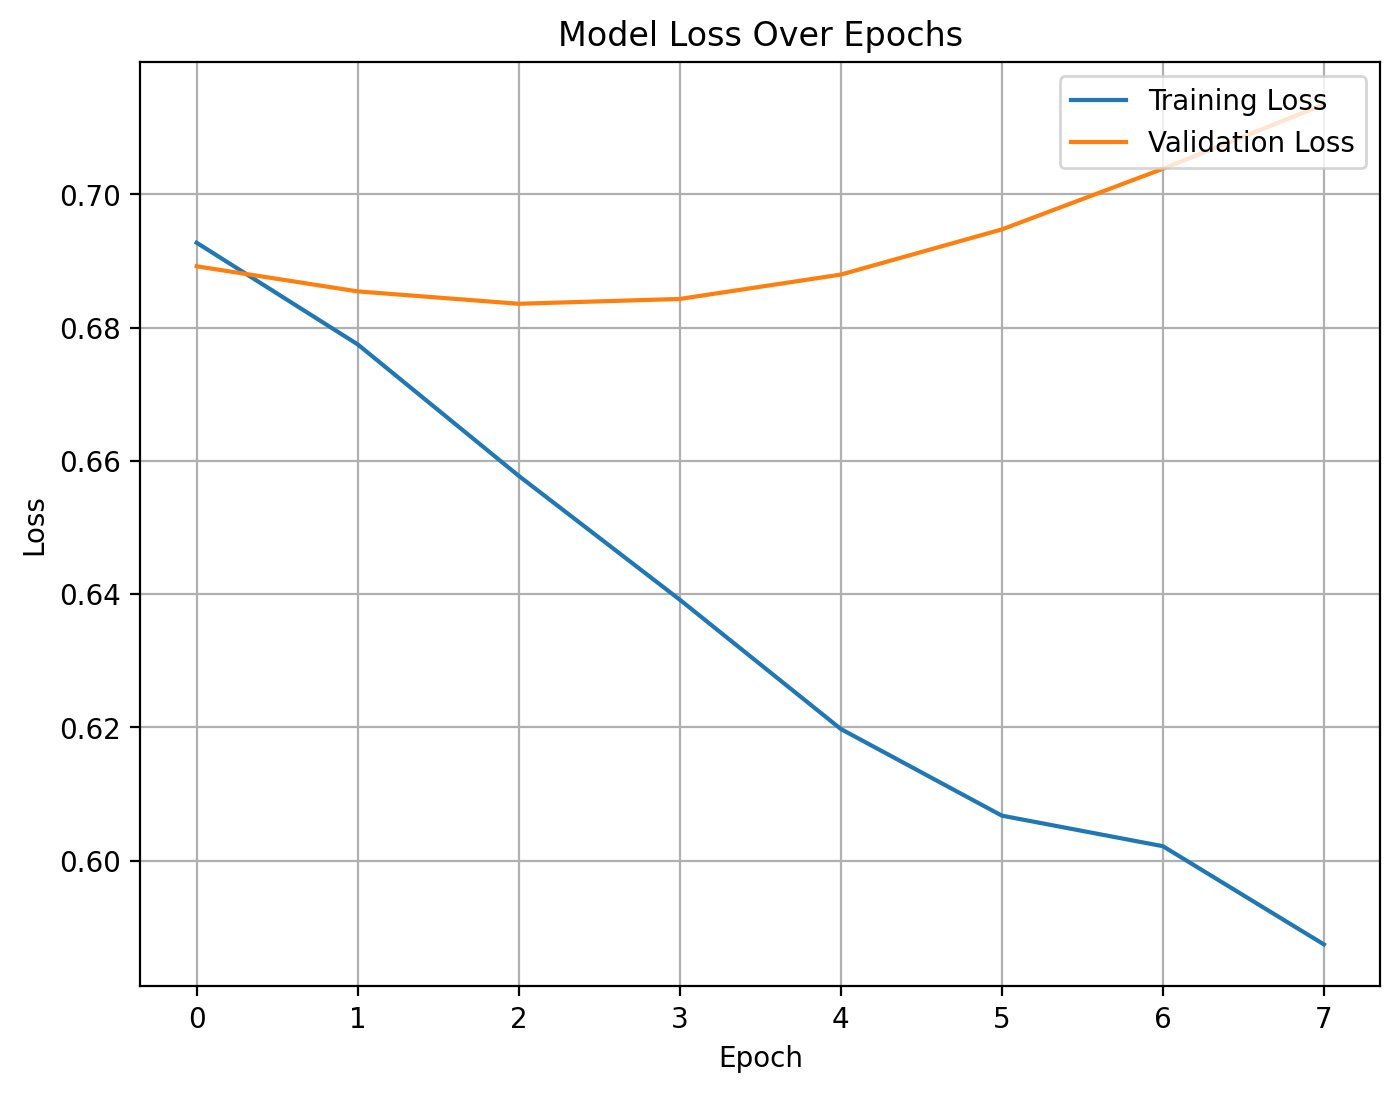

In [20]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [21]:
test_loss, test_accuracy = model.evaluate(x_test_flat, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5300 - loss: 0.6734
Test Accuracy: 52.94%


In [24]:
pip install keras-tuner --upgrade

   ---------------------------------------- 0.0/129.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/129.1 kB ? eta -:--:--
   ------ --------------------------------- 20.5/129.1 kB ? eta -:--:--
   --------- ----------------------------- 30.7/129.1 kB 435.7 kB/s eta 0:00:01
   ------------------------ -------------- 81.9/129.1 kB 573.4 kB/s eta 0:00:01
   -------------------------------------- 129.1/129.1 kB 691.3 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [25]:
import kerastuner as kt

def model_builder(hp):
    # Hyperparameters to tune
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    hp_dropout = hp.Float('dropout', min_value=0.0, max_value=0.5, default=0.25, step=0.05)
    
    model = keras.Sequential([
        layers.Flatten(input_shape=(180*180*3,)),
        layers.Dense(units=hp_units, activation='relu'),
        layers.Dropout(hp_dropout),
        layers.Dense(units=hp_units, activation='relu'),
        layers.Dropout(hp_dropout),
        layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, step=1e-4)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Instantiate the tuner
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

# Early stopping callback
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Execute the hyperparameter search
tuner.search(x_train_flat, y_train,
             epochs=50,
             validation_data=(x_val_flat, y_val),
             callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


Reloading Tuner from my_dir\intro_to_kt\tuner0.json


C:\Users\jahna\AppData\Local\Temp\ipykernel_20768\2028026864.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [26]:
from tensorflow.keras import regularizers

def build_regularized_mlp_model(input_shape, num_classes, dropout_rate=0.2, l1=1e-5, l2=1e-4):
    model = keras.Sequential([
        layers.Flatten(input_shape=input_shape),
        layers.Dense(512, activation='relu',
                     kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)),
        layers.Dropout(dropout_rate),
        layers.Dense(256, activation='relu',
                     kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='sigmoid')
    ])
    return model

# Now let's use the function with a new dropout rate and L1/L2 regularization
model = build_regularized_mlp_model(input_shape=(180*180*3,),
                                    num_classes=1,
                                    dropout_rate=0.3,  # Adjust dropout rate as needed
                                    l1=1e-5,           # L1 regularization factor
                                    l2=1e-4)           # L2 regularization factor

# Proceed with model compilation and fitting as before
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

# Normalize and reshape the data if not already done so
x_train_flat = x_train.reshape(-1, 180*180*3).astype('float32') / 255
x_val_flat = x_val.reshape(-1, 180*180*3).astype('float32') / 255
x_test_flat = x_test.reshape(-1, 180*180*3).astype('float32') / 255

# Train the model with the flattened data
history = model.fit(
    x_train_flat, y_train,
    batch_size=128,
    epochs=50,
    validation_data=(x_val_flat, y_val),
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5760 - loss: 2.8331 - val_accuracy: 0.5098 - val_loss: 2.7596
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6769 - loss: 2.7472 - val_accuracy: 0.5098 - val_loss: 2.6784
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6717 - loss: 2.6546 - val_accuracy: 0.5098 - val_loss: 2.5983
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6795 - loss: 2.5634 - val_accuracy: 0.5098 - val_loss: 2.5206
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6639 - loss: 2.4753 - val_accuracy: 0.5098 - val_loss: 2.4462
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 979ms/step - accuracy: 0.6743 - loss: 2.3841 - val_accuracy: 0.5098 - val_loss: 2.3755
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 963ms/step - accuracy: 0.6691 - loss: 2.3033 - val_accuracy: 0.5098 - val_loss: 2.3077
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 971ms/step - accuracy: 0.6665 - loss: 2.2280 - val_accuracy: 0.5098 - val_loss: 2.2430
Epoch 9

In [27]:
test_loss, test_accuracy = model.evaluate(x_test_flat, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.5300 - loss: 0.8189
Test Accuracy: 52.94%


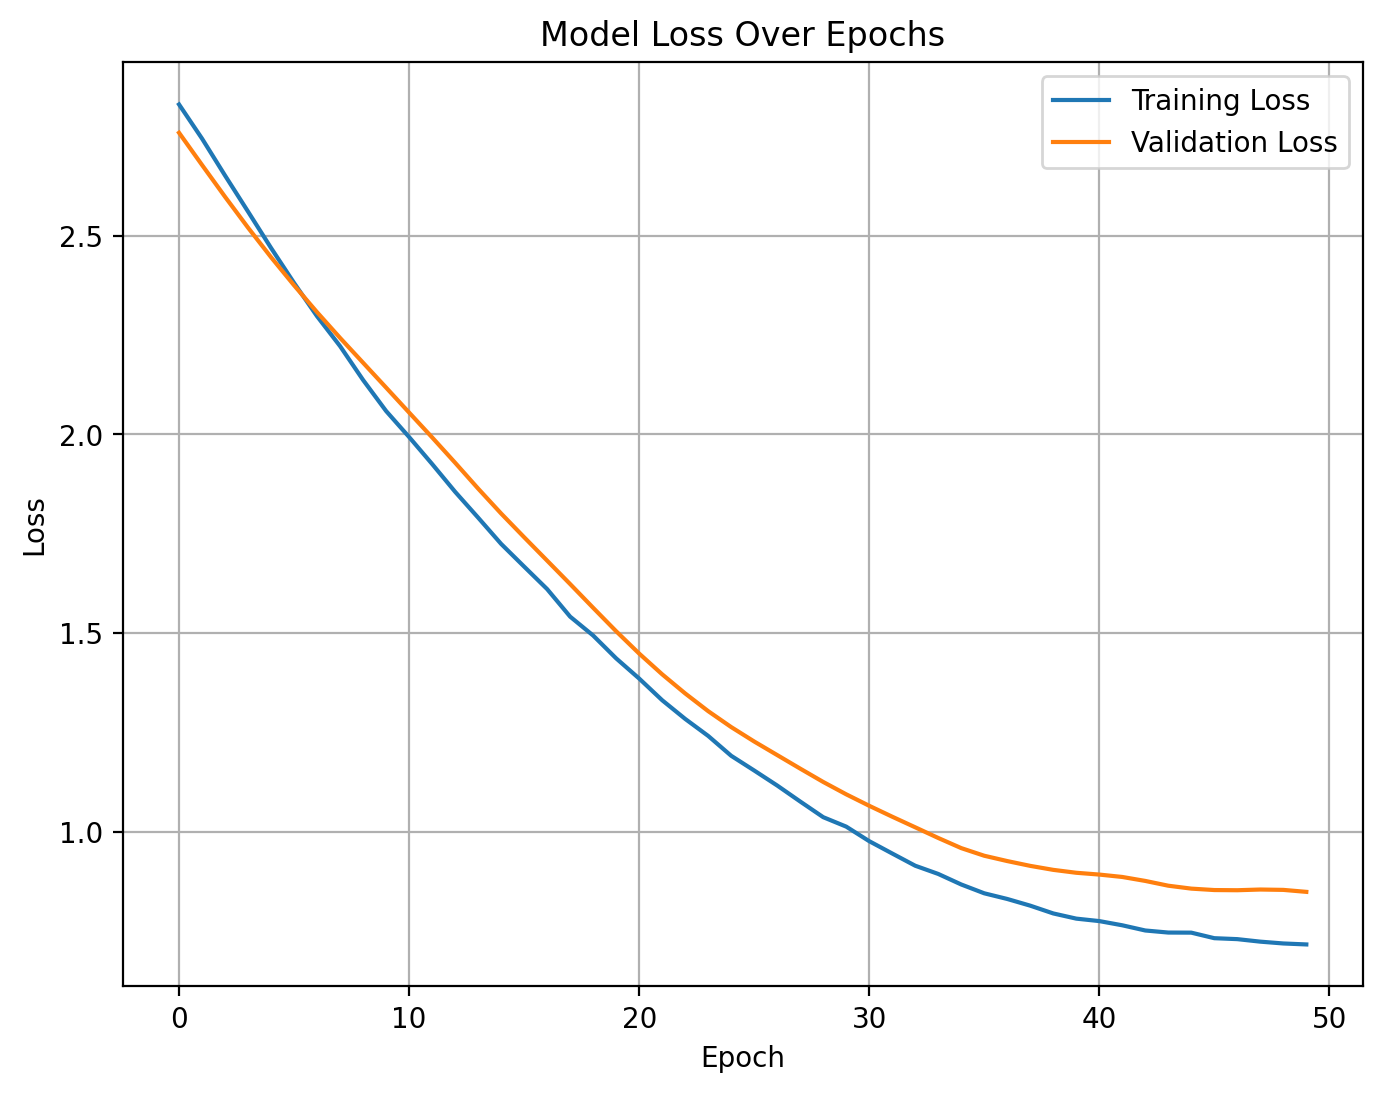

In [28]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [29]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import numpy as np
from PIL import Image


base_model = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freezing all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

top_model = base_model.output
top_model = Flatten(name="flatten")(top_model)
top_model = Dense(512, activation="relu")(top_model)
top_model = Dropout(0.5)(top_model)  # Using a dropout rate of 0.5
top_model = Dense(2, activation="softmax")(top_model)  # Using softmax for multi-class classification

model = Model(inputs=base_model.input, outputs=top_model)

# Compile the model
model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])

# Initialize the data generator for augmenting images 
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Function to preprocess the image data
def preprocess_images(image_tensors):
    processed_images = []
    for image in image_tensors:
        # Convert the image to uint8 if it's not already in uint8
        if image.dtype != np.uint8:
            image = (image * 255).astype(np.uint8)
        # Convert the image to RGB mode if it's not already in RGB
        if image.shape[-1] != 3:
            image = np.array(Image.fromarray(image).convert("RGB"))
        # Resize the image to (224, 224)
        resized_image = np.array(Image.fromarray(image).resize((224, 224)))
        processed_images.append(resized_image)
    return np.array(processed_images)

# Preprocess image data
x_train_processed = preprocess_images(x_train)
x_val_processed = preprocess_images(x_val)
x_test_processed = preprocess_images(x_test)

# Convert pixel values to float32 and normalize to be between 0 and 1
x_train_processed = x_train_processed.astype(np.float32) / 255.0
x_val_processed = x_val_processed.astype(np.float32) / 255.0
x_test_processed = x_test_processed.astype(np.float32) / 255.0

# Convert labels to categorical (if they are not already in binary form)
y_train_categorical = to_categorical(y_train, num_classes=2)
y_val_categorical = to_categorical(y_val, num_classes=2)
y_test_categorical = to_categorical(y_test, num_classes=2)

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model with augmented and preprocessed data
history = model.fit(
    aug.flow(x_train_processed, y_train_categorical, batch_size=32),
    validation_data=(x_val_processed, y_val_categorical),
    steps_per_epoch=len(x_train_processed) // 32,
    epochs=50,  # Adjust the number of epochs based on the convergence observed during training
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test_processed, y_test_categorical, verbose=1)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")


Epoch 1/50


C:\Users\jahna\anaconda\jupyter\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 32s 8s/step - accuracy: 0.5221 - loss: 0.8321 - val_accuracy: 0.5098 - val_loss: 1.0751
Epoch 2/50
1/4 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.6875 - loss: 0.7151

C:\Users\jahna\anaconda\jupyter\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.6875 - loss: 0.7151 - val_accuracy: 0.5098 - val_loss: 1.0617
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 29s 8s/step - accuracy: 0.7079 - loss: 0.6377 - val_accuracy: 0.7451 - val_loss: 0.5771
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.7500 - loss: 0.6537 - val_accuracy: 0.6471 - val_loss: 0.5879
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 29s 8s/step - accuracy: 0.6326 - loss: 0.6623 - val_accuracy: 0.6078 - val_loss: 0.7374
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.7188 - loss: 0.4833 - val_accuracy: 0.5098 - val_loss: 0.8590
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 30s 8s/step - accuracy: 0.6761 - loss: 0.5827 - val_accuracy: 0.6863 - val_loss: 0.6801
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.8438 - loss: 0.4826 - val_accuracy: 0.7647 - val_loss: 0.5919
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.7729 - loss: 0.5416
Test accuracy: 78.43%


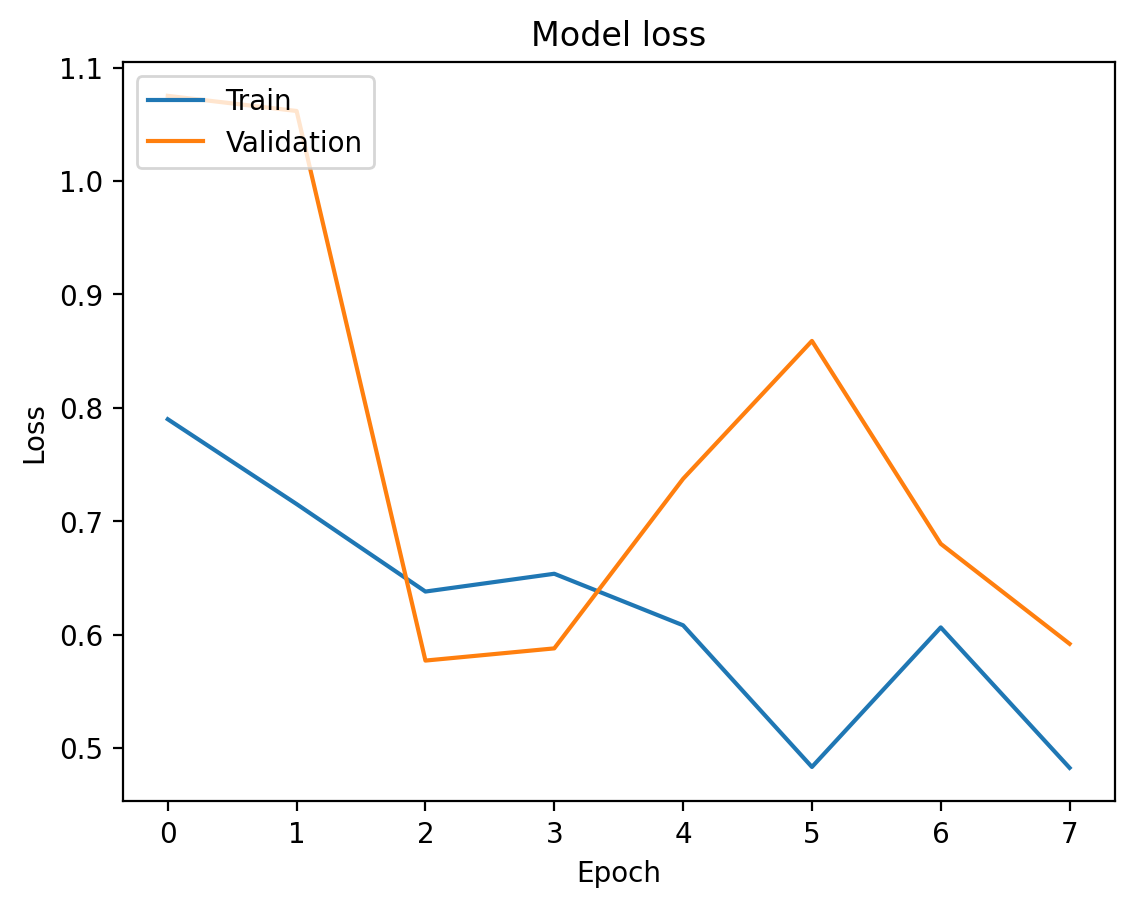

In [30]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def build_mlp_model():
    model = keras.Sequential([
        layers.Flatten(input_shape=(180, 180, 3)),  # Flatten the input image to a vector
        layers.Dense(512, activation='relu'),  # First hidden layer with ReLU activation
        layers.Dropout(0.2),  # Dropout for regularization
        layers.Dense(256, activation='relu'),  # Second hidden layer
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])
    return model

model = build_mlp_model()
model.summary()

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',  # Use binary crossentropy for binary classification
    metrics=['accuracy']
)

# Normalize pixel values if not already done
x_train = x_train.astype('float32') / 255
x_val = x_val.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Train the model
history = model.fit(
    x_train, y_train,
    batch_size=128,
    epochs=100,  # Adjust the number of epochs based on initial tests and desired accuracy
    validation_data=(x_val, y_val),
    verbose=1
)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)                  │ (None, 97200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 512)                 │      49,766,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,898,497 (190.35 MB)

 Trainable params: 49,898,497 (190.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 836ms/step - accuracy: 0.4489 - loss: 0.6803 - val_accuracy: 0.5098 - val_loss: 0.7633
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step - accuracy: 0.6665 - loss: 0.6044 - val_accuracy: 0.5098 - val_loss: 0.9019
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step - accuracy: 0.6665 - loss: 0.6502 - val_accuracy: 0.5098 - val_loss: 0.8229
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step - accuracy: 0.6769 - loss: 0.5820 - val_accuracy: 0.5098 - val_loss: 0.7032
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step - accuracy: 0.6717 - loss: 0.5535 - val_accuracy: 0.5098 - val_loss: 0.6626
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step - accuracy: 0.7120 - loss: 0.5567 - val_accuracy: 0.5490 - val_loss: 0.6591
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step - accuracy: 0.7164 - loss: 0.5448 - val_accuracy: 0.5490 - val_loss: 0.6723
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step - accuracy: 0.7016 - loss: 0.5128 - val_accuracy: 0.5098 - v

In [17]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7937 - loss: 2.0497
Test Accuracy: 78.43%


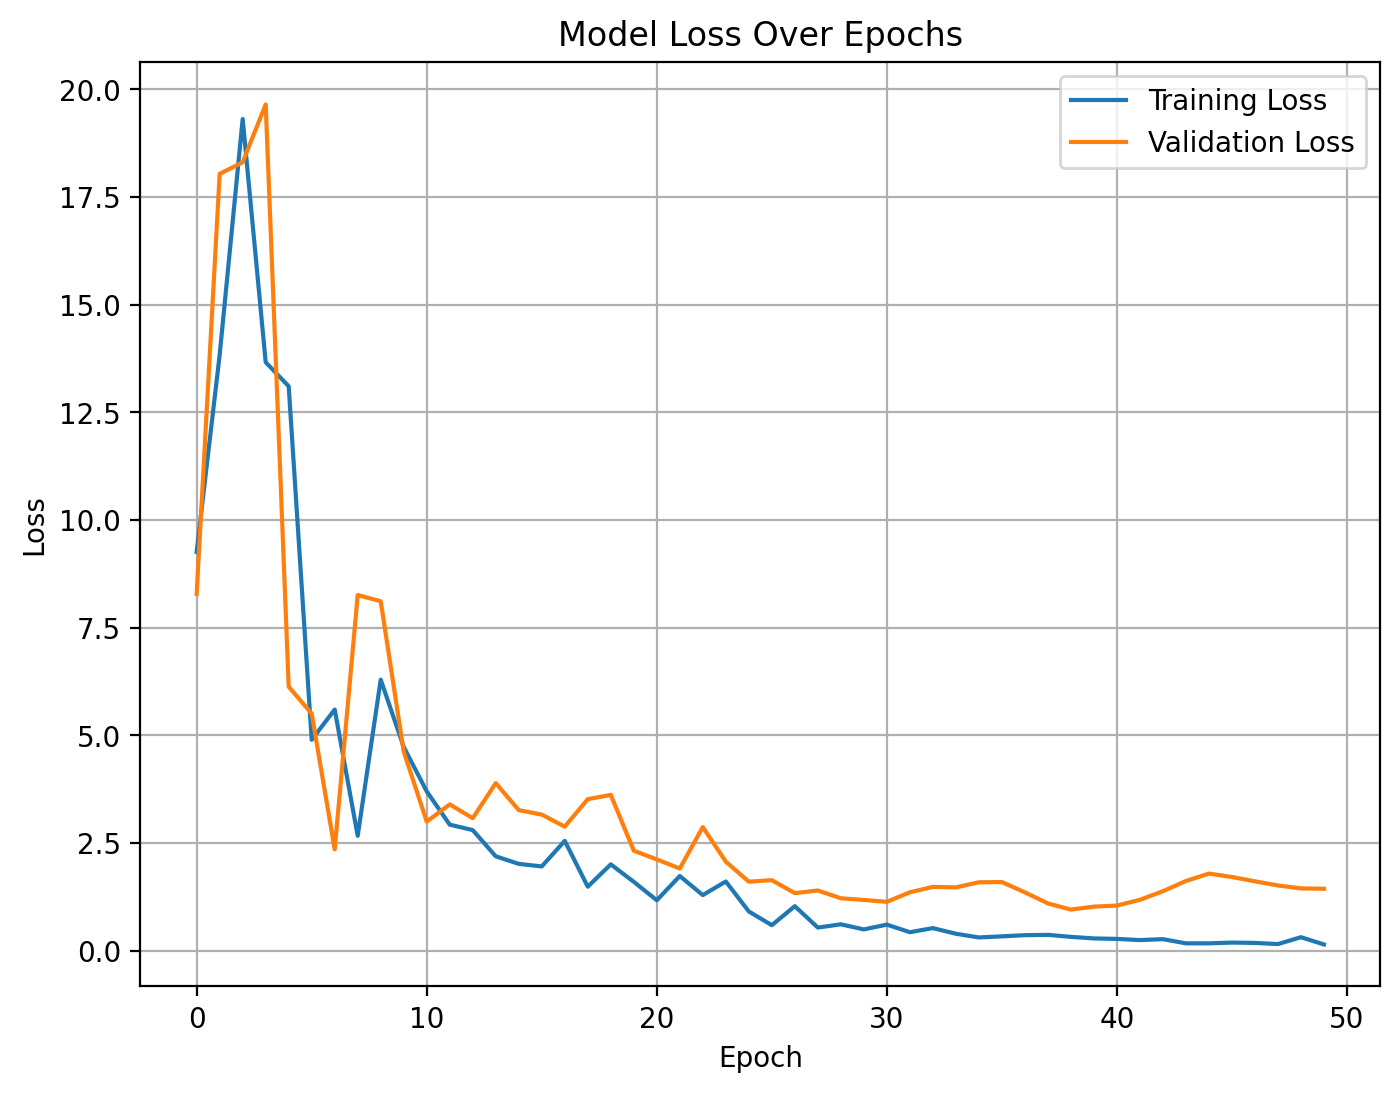

In [18]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
